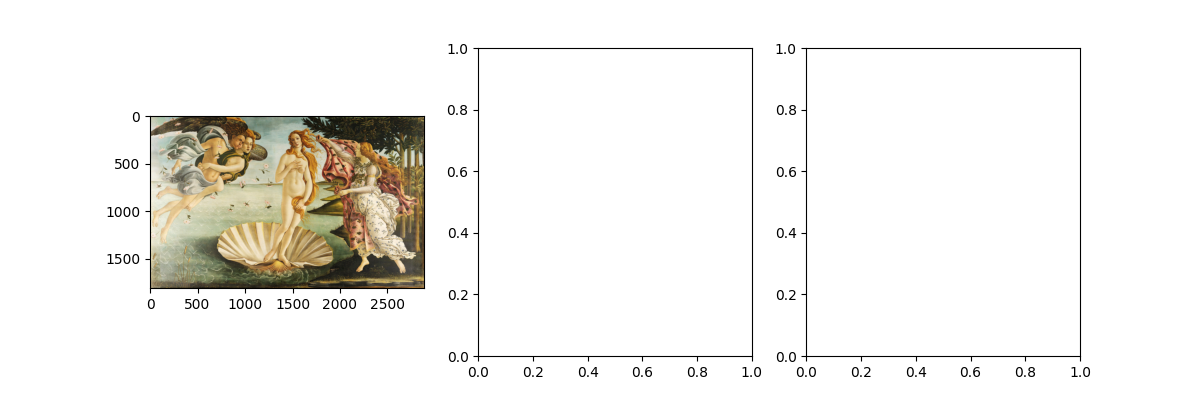

Coordinates: x=1729.7709141885084, y=1360.254637096774
VGG-19 Architecture Detected
Successfully loaded models/vgg19-d01eb7cb.pth
conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3
conv3_2: 256 256 3 3
conv3_3: 256 256 3 3
conv3_4: 256 256 3 3
conv4_1: 512 256 3 3
conv4_2: 512 512 3 3
conv4_3: 512 512 3 3
conv4_4: 512 512 3 3
conv5_1: 512 512 3 3
conv5_2: 512 512 3 3
conv5_3: 512 512 3 3
conv5_4: 512 512 3 3
Setting up style layer 2: relu1_1
Setting up style layer 7: relu2_1
Setting up style layer 12: relu3_1
Setting up style layer 21: relu4_1
Setting up content layer 23: relu4_2
Setting up style layer 30: relu5_1
Capturing content targets
nn.Sequential ( 
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> (24) -> (25) -> (26) -> (27) -> (28) -> (29) -> (30) -> (31) -> (32) -> (33) -> (34) -> (35) -> (36)

In [ ]:
import os
#os.chdir('path_to_code/code/Modern Style Transfer of Ancient Paintings')
os.chdir('/mnt/c/Users/huyue/OneDrive/桌面/INF573/code/Modern Style Transfer of Ancient Paintings')

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys

# Replace the placeholder with the actual path to the segment_anything module
segment_anything_path = ''
sys.path.append(segment_anything_path)

from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image


# Helper function to apply a mask to an image
def apply_mask_to_image(image, mask):
    # Convert the mask to a 3-channel image
    mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

    # Apply the mask to the image
    masked_image = np.where(mask_3d, image, 0)
    return masked_image


import os
#os.chdir('path_to_code/code/Modern Style Transfer of Ancient Paintings')
os.chdir('/mnt/c/Users/huyue/OneDrive/桌面/INF573/code/Modern Style Transfer of Ancient Paintings')

def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

checkpoint = "examples/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=checkpoint)


import warnings

onnx_model_path = "sam_onnx_example.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )    
        
        
# run script to transfer style
path_to_image = 'examples/images/venus.jpg'

img_position = mpimg.imread( path_to_image)
image = cv2.imread( path_to_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        


ort_session = onnxruntime.InferenceSession(onnx_model_path)

sam.to(device='cuda')
predictor = SamPredictor(sam)
predictor.set_image(image)

image_embedding = predictor.get_image_embedding().cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img_position)


# Main function to handle the click event
def onclick(event): 
    
    import numpy as np
    import os
    #os.chdir('path_to_code/code/Modern Style Transfer of Ancient Paintings')
    os.chdir('/mnt/c/Users/huyue/OneDrive/桌面/INF573/code/Modern Style Transfer of Ancient Paintings')
    
    # First module : Get the clicked coordinates！
    #-------------------------
    global image_embedding  # Ensure we use the globally initialized embedding
    if event.xdata is not None and event.ydata is not None:
        print(f'Coordinates: x={event.xdata}, y={event.ydata}')
        input_point = np.array([[event.xdata, event.ydata]])
        input_label = np.array([1])
    #-------------------------
        
        
        # Second module : Get the mask and segment the object！
        #---------------------------------
        onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
        onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)
        onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
        onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
        onnx_has_mask_input = np.zeros(1, dtype=np.float32)
        ort_inputs = {
            "image_embeddings": image_embedding,
            "point_coords": onnx_coord,
            "point_labels": onnx_label,
            "mask_input": onnx_mask_input,
            "has_mask_input": onnx_has_mask_input,
            "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
        }
        
        # Run the model
        masks, _, low_res_logits = ort_session.run(None, ort_inputs)
        masks = masks > predictor.model.mask_threshold
        
        #------------------------
        from PIL import Image
        import numpy as np
        
        # Apply the mask to the image
        masked_image = apply_mask_to_image(image, masks[0, 0])

        # Convert the masked image to a PIL Image and save or display it
        output_image = Image.fromarray(masked_image.astype('uint8'))
        
        

        import os
        #os.chdir('path_to_code/code/Modern Style Transfer of Ancient Paintings')
        os.chdir('/mnt/c/Users/huyue/OneDrive/桌面/INF573/code/Modern Style Transfer of Ancient Paintings/transfer_style_module')



        # Load the original image and the segmented object

        original_image_before =image.copy()

        original_image = Image.fromarray(original_image_before.astype('uint8'))
        segmented_object = output_image  # Assuming we're using the first mask

        # Convert the segmented object image to a binary mask
        # Assuming the background is black and the object is white
        segmented_mask = segmented_object.convert('L')  # Convert to grayscale
        threshold = 1  # Pixels value above this threshold will be considered part of the mask
        binary_mask = segmented_mask.point(lambda p: p > threshold and 255)

        # For visualization, let's display the original image, the segmented object, and the binary mask
        binary_mask_image = Image.fromarray(np.array(binary_mask))

        # Saving the binary mask for user's reference
        binary_mask_image_path = './binary_mask_image.png'
        binary_mask_image.save(binary_mask_image_path)
        #-----------------

        # Third module : Get the style transferred image！
        #---------------------------------
        !python neural_style.py -gpu 0 -backend cudnn -print_iter 1
        #---------------------------------


        # Fourth module : Get the final image！
        #-----------------------------------------------------------------
        # We have already run the style transfer and have the resulting image
        # For example, the style-transferred image is saved as "out.jpg"
        styled_image_path = "./object_transfered/out.png"

        # Load the style transferred image
        styled_image = Image.open(styled_image_path)

        # Load the binary mask created previously
        # Assuming it's saved as "binary_mask_image.png"
        binary_mask_path = './binary_mask_image.png'
        binary_mask = Image.open(binary_mask_path)

        # Load the original content image

        # Make sure all images are the same size
        binary_mask = binary_mask.resize(original_image.size)
        styled_image = styled_image.resize(original_image.size)

        # Convert binary mask to boolean mask
        binary_mask_array = np.array(binary_mask)
        boolean_mask = binary_mask_array > 128  # Assuming mask is 255 for object, 0 for background

        # Prepare an empty canvas with the same size as the original image
        final_image = Image.new("RGB", original_image.size)

        # Split the images into channels for processing
        r_s, g_s, b_s = styled_image.split()
        r_o, g_o, b_o = original_image.split()

        # Apply the boolean mask to each channel
        r = np.where(boolean_mask, r_s, r_o)
        g = np.where(boolean_mask, g_s, g_o)
        b = np.where(boolean_mask, b_s, b_o)

        # Merge the channels back
        final_image = Image.merge("RGB", (Image.fromarray(r), Image.fromarray(g), Image.fromarray(b)))

        # Save the final image
        final_image_path = './final_output.jpg'
        final_image.save(final_image_path)

        # Now the final_image in my application
        print(f"Final image with style transferred only to the segmented object is saved as {final_image_path}")
        #---------------------------------
        
        
        
        # Clear the current axes and plot the image, mask, and points again
        axs[0].clear()
        axs[0].imshow(image)
        show_mask(masks, axs[0])
        show_points(input_point, input_label, axs[0])
        
        # Mask the image
        mask = masks[0, 0]  # Assuming we're using the first mask
        mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        masked_image = np.where(mask_3d, image, 0)
        
        
        # Show the masked image in the second subplot
        axs[1].clear()
        axs[1].imshow(masked_image)
        axs[1].axis('off')  # Turn off the axis for the masked image

        axs[2].clear()
        axs[2].imshow(final_image)
        axs[2].axis('off')  # Turn off the axis for the masked image        
        
        # Update the figure canvas
        plt.draw()


cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()